In [16]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

from rbd import rbd
from gather_basis_statistics import iterate_stats
from error_statistics import calculate_error_stats
from image_dataset_stats import crunch_images

import seaborn as sns
import pandas as pd
from sklearn import preprocessing
from PIL import Image
from sklearn.decomposition import PCA

from timeit import default_timer
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Experiment 1: Read in an image, visualize a RBD approximation of the image, and compare performace to Numpy's SVD.

### _Original Image_

Dimensions of the input image:  (281, 325)


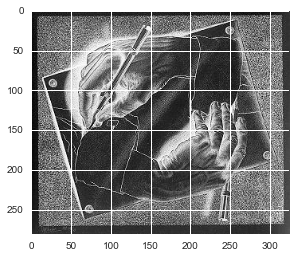

In [17]:
escher = mpimg.imread('images/DrawingHands.jpg')
print("Dimensions of the input image: ", escher.shape)
plt.imshow(escher)


### _Sample of RBD compression with 30 basis vectors_

Decomposition at dmax = 30
Dimensions of the input image:  (281, 325)
Runtime of RBD in seconds:  0.23940366599708796
MSE:  1478.20669039
NMSE:  0.0478196852106
RMSD:  38.4474536269
NRMSD:  0.0260095248363
PSNR:  16.43345197295899


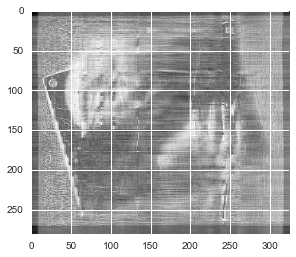

In [18]:
#Read in all of the ouptut from RBD of 30 basis vectors
start = default_timer()
X,Y,T,d,e_cur,Er,i,used_i,complete = rbd(escher, dmax=30, Er=-np.inf)
end = default_timer()

#Form the compression
escher_compression = np.dot(Y, T)
#Round each element of the decomposition to nearest integer. Necessary step for plotting. 
escher_compression = np.rint(escher_compression).astype(int)

#Calculate error statistics.
MSE, NMSE, RMSD, NRMSD, PSNR = calculate_error_stats(X, escher_compression)

#View the image and print statistics
print("Decomposition at dmax = 30")
print("Dimensions of the input image: ", escher_compression.shape)
print("Runtime of RBD in seconds: ", end - start)
print("MSE: ", MSE)
print("NMSE: ", NMSE)
print("RMSD: ", RMSD)
print("NRMSD: ", NRMSD)
print("PSNR: ", PSNR)

plt.imshow(escher_compression)


### _Compare to SVD compression_

Runtime of SVD in seconds:  0.040767604019492865
MSE:  991.341778239
NMSE:  0.031572379772
RMSD:  31.4855804812
NRMSD:  0.0317605705442
PSNR:  18.168569517777872


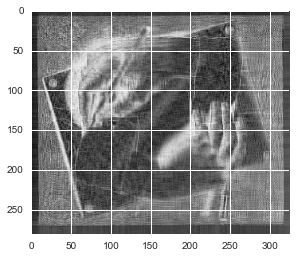

In [19]:
start = default_timer()
L, S, R = np.linalg.svd(escher, full_matrices=False)
stop = default_timer()

r = 30
Rr = R[:r,:]
Lr = L[:,:r]
Sd = np.diag(S)
Sr = Sd[0:r, 0:r]

Ar = Lr.dot(Sr.dot(Rr))
MSE, NMSE, RMSD, NRMSD, PSNR = calculate_error_stats(X, Ar)

print("Runtime of SVD in seconds: ", stop - start)
plt.imshow(Ar)
print("MSE: ", MSE)
print("NMSE: ", NMSE)
print("RMSD: ", RMSD)
print("NRMSD: ", NRMSD)
print("PSNR: ", PSNR)

**_Numpy's SVD is still way better than my RBD, even though RBD should be faster in theory. One explanation for this is that numpy.linalg.svd is written in Fortran while my RBD algorithm is written in Python, a high level programming language. _**

# Experiment 2: Apply RBD to 150 images and plot MSE and PSNR error metrics.

In [15]:
"""DON'T RUN MORE THAN ONCE, THIS TAKES HALF AN HOUR
I've included a file you can read in: face150_stats.csv

faces150_data = crunch_images(return_df=False)

huge_number_of_basis, huge_runtime, huge_e_cur_data, huge_MSE_data, huge_NMSE_data, huge_RMSD_data, huge_NRMSD_data, huge_PSNR_data = faces150_data

faces150_df = pd.DataFrame(
            {'basis_count': huge_number_of_basis,
            'runtime': huge_runtime,
            'MSE': huge_MSE_data,
            'NMSE': huge_NMSE_data,
            'RMSD': huge_RMSD_data,
            'NRMSD': huge_NRMSD_data,
            'PSNR': huge_PSNR_data})

#faces150_df.to_csv('face150_stats.csv')"""


In [85]:
faces150_df = pd.read_csv('face150_stats.csv')

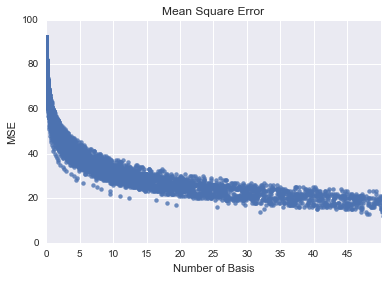

In [87]:
"""View a figure for each error metric over basis_count"""

pylab.figure()
MSE_plot = sns.regplot('MSE', 'basis_count', data= faces150_df, fit_reg=False)
MSE_plot.set_title("Mean Square Error")
MSE_plot.set_ylabel("MSE")
MSE_plot.set_xlabel("Number of Basis")
MSE_plot.axes.set_xlim(0,50)
MSE_plot.axes.set_ylim(0,100)
MSE_plot.set_xticks(range(0,50,5))
plt.show()

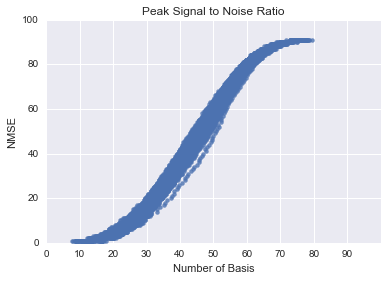

In [91]:
pylab.figure()
PSNR_plot = sns.regplot(faces150_df.PSNR, faces150_df.basis_count, data= faces150_df, fit_reg=False)
PSNR_plot.set_title("Peak Signal to Noise Ratio")
PSNR_plot.set_ylabel("NMSE")
PSNR_plot.set_xlabel("Number of Basis")
PSNR_plot.axes.set_xlim(0,100)
PSNR_plot.axes.set_ylim(0,100)
PSNR_plot.set_xticks(range(0,100,10))
plt.show()